In [1]:
from __future__ import annotations

import abc
import collections
import copy
import math
import random
import typing

import numpy as np
from river import base, metrics, stats
from river.drift import ADWIN, NoDrift
from river.tree.hoeffding_tree_classifier import HoeffdingTreeClassifier # For BaseForest type hints
from river.tree.hoeffding_tree_regressor import HoeffdingTreeRegressor
from river.tree.nodes.arf_htr_nodes import RandomLeafAdaptive, RandomLeafMean, RandomLeafModel
from river.tree.splitter import Splitter
from river.utils.random import poisson

import logging
import matplotlib.pyplot as plt

# Configure basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ================================================================
# Existing BaseForest, BaseTreeRegressor (from user's context)
# ARFRegressor (adapted from user's context with corrected predict_one)
# ================================================================
class BaseForest(base.Ensemble):
    _FEATURES_SQRT = "sqrt"
    _FEATURES_LOG2 = "log2"

    def __init__(
        self,
        n_models: int,
        max_features: bool | str | int,
        lambda_value: int,
        drift_detector: base.DriftDetector,
        warning_detector: base.DriftDetector,
        metric: metrics.base.MultiClassMetric | metrics.base.RegressionMetric,
        disable_weighted_vote,
        seed,
    ):
        super().__init__([])
        self.n_models = n_models
        self.max_features = max_features
        self.lambda_value = lambda_value
        self.metric = metric
        self.disable_weighted_vote = disable_weighted_vote
        self.drift_detector = drift_detector
        self.warning_detector = warning_detector
        self.seed = seed
        self._rng = random.Random(self.seed)

        self._warning_detectors: list[base.DriftDetector] = []
        self._warning_detection_disabled = True
        if not isinstance(self.warning_detector, NoDrift):
            self._warning_detection_disabled = False

        self._drift_detectors: list[base.DriftDetector] = []
        self._drift_detection_disabled = True
        if not isinstance(self.drift_detector, NoDrift):
            self._drift_detection_disabled = False

        self._background: list[HoeffdingTreeClassifier | BaseTreeRegressor | None] = []
        self._metrics: list[metrics.base.Metric] = []

        self._warning_tracker: dict = collections.defaultdict(int) if not self._warning_detection_disabled else {}
        self._drift_tracker: dict = collections.defaultdict(int) if not self._drift_detection_disabled else {}
        # Initialize lists in _init_ensemble based on self.n_models

    @property
    def _min_number_of_models(self): return 0

    @classmethod
    def _unit_test_params(cls): yield {"n_models": 3}

    def _unit_test_skips(self): return {"check_shuffle_features_no_impact"}

    @abc.abstractmethod
    def _drift_detector_input(self, tree_id: int, y_true, y_pred) -> int | float:
        raise NotImplementedError

    @abc.abstractmethod
    def _new_base_model(self) -> HoeffdingTreeClassifier | BaseTreeRegressor:
        raise NotImplementedError

    def n_warnings_detected(self, tree_id: int | None = None) -> int:
        if self._warning_detection_disabled: return 0
        count = 0
        num_models = len(self.data)
        if self._warning_tracker:
            if tree_id is None: count = sum(self._warning_tracker.values())
            elif tree_id < num_models: count = self._warning_tracker.get(tree_id, 0)
        return count

    def n_drifts_detected(self, tree_id: int | None = None) -> int:
        if self._drift_detection_disabled: return 0
        count = 0
        num_models = len(self.data)
        if self._drift_tracker:
            if tree_id is None: count = sum(self._drift_tracker.values())
            elif tree_id < num_models: count = self._drift_tracker.get(tree_id, 0)
        return count

    def learn_one(self, x: dict, y: base.typing.Target, **kwargs):
        raise NotImplementedError # To be implemented by subclasses

    def _init_ensemble(self, features: list):
        self._set_max_features(len(features))
        self.data = [self._new_base_model() for _ in range(self.n_models)]

        if not self._warning_detection_disabled:
            self._warning_detectors = [self.warning_detector.clone() for _ in range(self.n_models)]
            self._background = [None] * self.n_models
        else:
            self._warning_detectors = []
            self._background = []

        if not self._drift_detection_disabled:
            self._drift_detectors = [self.drift_detector.clone() for _ in range(self.n_models)]
        else:
            self._drift_detectors = []

        self._metrics = [self.metric.clone() for _ in range(self.n_models)]

        if self._warning_tracker: self._warning_tracker.clear()
        if self._drift_tracker: self._drift_tracker.clear()

    def _set_max_features(self, n_features):
        orig_max_features = self.max_features
        if self.max_features == "sqrt": self.max_features = round(math.sqrt(n_features))
        elif self.max_features == "log2": self.max_features = round(math.log2(n_features))
        elif isinstance(self.max_features, int): pass
        elif isinstance(self.max_features, float): self.max_features = int(self.max_features * n_features)
        elif self.max_features is None: self.max_features = n_features
        else: raise AttributeError(f"Invalid max_features: {orig_max_features}...")
        if self.max_features < 0: self.max_features += n_features
        if self.max_features <= 0: self.max_features = 1
        if self.max_features > n_features: self.max_features = n_features

class BaseTreeRegressor(HoeffdingTreeRegressor):
    def __init__(
        self, max_features: int = 2, grace_period: int = 200, max_depth: int | None = None,
        delta: float = 1e-7, tau: float = 0.05, leaf_prediction: str = "adaptive",
        leaf_model: base.Regressor | None = None, model_selector_decay: float = 0.95,
        nominal_attributes: list | None = None, splitter: Splitter | None = None,
        min_samples_split: int = 5, binary_split: bool = False, max_size: float = 100.0,
        memory_estimate_period: int = 1000000, stop_mem_management: bool = False,
        remove_poor_attrs: bool = False, merit_preprune: bool = True,
        rng: random.Random | None = None,
    ):
        super().__init__(
            grace_period=grace_period, max_depth=max_depth, delta=delta, tau=tau,
            leaf_prediction=leaf_prediction, leaf_model=leaf_model,
            model_selector_decay=model_selector_decay, nominal_attributes=nominal_attributes,
            splitter=splitter, min_samples_split=min_samples_split, binary_split=binary_split,
            max_size=max_size, memory_estimate_period=memory_estimate_period,
            stop_mem_management=stop_mem_management, remove_poor_attrs=remove_poor_attrs,
            merit_preprune=merit_preprune,
        )
        self.max_features = max_features
        self.rng = rng

    def _new_leaf(self, initial_stats=None, parent=None):
        if parent is not None: depth = parent.depth + 1
        else: depth = 0
        leaf_model = None
        if self.leaf_prediction in {self._MODEL, self._ADAPTIVE}:
            if parent is None: leaf_model = copy.deepcopy(self.leaf_model)
            else:
                try: leaf_model = copy.deepcopy(parent._leaf_model)
                except AttributeError: leaf_model = copy.deepcopy(self.leaf_model)

        if self.leaf_prediction == self._TARGET_MEAN:
            return RandomLeafMean(initial_stats, depth, self.splitter, self.max_features, self.rng)
        elif self.leaf_prediction == self._MODEL:
            return RandomLeafModel(initial_stats, depth, self.splitter, self.max_features, self.rng, leaf_model=leaf_model)
        else:  # adaptive
            new_adaptive = RandomLeafAdaptive(initial_stats, depth, self.splitter, self.max_features, self.rng, leaf_model=leaf_model)
            if parent is not None and isinstance(parent, RandomLeafAdaptive):
                new_adaptive._fmse_mean = parent._fmse_mean; new_adaptive._fmse_model = parent._fmse_model
            return new_adaptive

class ARFRegressor(BaseForest, base.Regressor):
    _MEAN = "mean"
    _MEDIAN = "median"
    _VALID_AGGREGATION_METHOD = [_MEAN, _MEDIAN]

    def __init__(
        self, n_models: int = 10, max_features="sqrt", aggregation_method: str = "mean",
        lambda_value: int = 6, metric: metrics.base.RegressionMetric | None = None,
        disable_weighted_vote=True, # Default in River's ARFRegressor
        drift_detector: base.DriftDetector | None = None, warning_detector: base.DriftDetector | None = None,
        grace_period: int = 50, max_depth: int | None = None, delta: float = 0.01, tau: float = 0.05,
        leaf_prediction: str = "adaptive", leaf_model: base.Regressor | None = None,
        model_selector_decay: float = 0.95, nominal_attributes: list | None = None,
        splitter: Splitter | None = None, min_samples_split: int = 5, binary_split: bool = False,
        max_size: float = 500.0, memory_estimate_period: int = 2_000_000,
        stop_mem_management: bool = False, remove_poor_attrs: bool = False, merit_preprune: bool = True,
        seed: int | None = None,
    ):
        super().__init__(
            n_models=n_models, max_features=max_features, lambda_value=lambda_value,
            metric=metric or metrics.MSE(), disable_weighted_vote=disable_weighted_vote,
            drift_detector=drift_detector or ADWIN(0.001),
            warning_detector=warning_detector or ADWIN(0.01), seed=seed,
        )
        self.grace_period=grace_period; self.max_depth=max_depth; self.delta=delta; self.tau=tau
        self.leaf_prediction=leaf_prediction; self.leaf_model=leaf_model
        self.model_selector_decay=model_selector_decay; self.nominal_attributes=nominal_attributes
        self.splitter=splitter; self.min_samples_split=min_samples_split; self.binary_split=binary_split
        self.max_size=max_size; self.memory_estimate_period=memory_estimate_period
        self.stop_mem_management=stop_mem_management; self.remove_poor_attrs=remove_poor_attrs
        self.merit_preprune=merit_preprune

        if aggregation_method in self._VALID_AGGREGATION_METHOD: self.aggregation_method = aggregation_method
        else: raise ValueError(f"Invalid aggregation_method: {aggregation_method}.")
        
        self._drift_norm: list[stats.Var] = [] # Initialized in _init_ensemble

    def _init_ensemble(self, features: list):
        super()._init_ensemble(features)
        self._drift_norm = [stats.Var() for _ in range(len(self.data))]

    @property
    def _mutable_attributes(self):
        return {"max_features", "aggregation_method", "lambda_value", "grace_period",
                "delta", "tau", "model_selector_decay"}

    def learn_one(self, x: dict, y: base.typing.Target, **kwargs):
        if len(self.data) == 0: self._init_ensemble(sorted(x.keys()))

        for i, model in enumerate(self.data):
            y_pred_tree = model.predict_one(x)
            if i < len(self._metrics): self._metrics[i].update(y_true=y, y_pred=y_pred_tree)

            k = poisson(rate=self.lambda_value, rng=self._rng)
            if k > 0:
                drift_input = None
                # Manage background learner
                if not self._warning_detection_disabled and self._background and i < len(self._background) and self._background[i] is not None:
                    self._background[i].learn_one(x=x, y=y, w=k)

                # Warning detection
                if not self._warning_detection_disabled and i < len(self._warning_detectors):
                    drift_input = self._drift_detector_input(i, y, y_pred_tree)
                    self._warning_detectors[i].update(drift_input)
                    if self._warning_detectors[i].drift_detected:
                        if self._background and i < len(self._background):
                            self._background[i] = self._new_base_model()
                        self._warning_detectors[i] = self.warning_detector.clone()
                        if self._warning_tracker: self._warning_tracker[i] += 1
                
                # Drift detection
                if not self._drift_detection_disabled and i < len(self._drift_detectors):
                    drift_input = drift_input if drift_input is not None else self._drift_detector_input(i, y, y_pred_tree)
                    self._drift_detectors[i].update(drift_input)
                    if self._drift_detectors[i].drift_detected:
                        if not self._warning_detection_disabled and self._background and i < len(self._background) and self._background[i] is not None:
                            self.data[i] = self._background[i]
                            if i < len(self._background): self._background[i] = None
                            if i < len(self._warning_detectors): self._warning_detectors[i] = self.warning_detector.clone()
                        else:
                            self.data[i] = self._new_base_model()
                        
                        # Reset states for the replaced tree
                        if i < len(self._drift_detectors): self._drift_detectors[i] = self.drift_detector.clone()
                        if i < len(self._metrics): self._metrics[i] = self.metric.clone()
                        if i < len(self._drift_norm): self._drift_norm[i] = stats.Var()
                        if self._drift_tracker: self._drift_tracker[i] += 1
                
                # Train the main model (or the newly replaced one)
                if i < len(self.data): # Ensure model still exists
                    self.data[i].learn_one(x=x, y=y, w=k)
        return self

    def predict_one(self, x: dict) -> base.typing.RegTarget:
        if len(self.data) == 0:
            self._init_ensemble(sorted(x.keys()))
            return 0.0

        predictions = np.zeros(len(self.data))
        for i, model in enumerate(self.data):
            predictions[i] = model.predict_one(x)

        if self.aggregation_method == self._MEDIAN:
            return float(np.median(predictions)) if len(predictions) > 0 else 0.0

        # For _MEAN aggregation:
        if self.disable_weighted_vote:
            return float(np.mean(predictions)) if len(predictions) > 0 else 0.0
        else:  # Weighted Mean
            raw_metric_values = np.zeros(len(self.data))
            sum_valid_metric_values = 0.0
            valid_indices = []

            for i in range(len(self.data)):
                metric_val = self._metrics[i].get()
                if isinstance(metric_val, (int, float)) and not (math.isnan(metric_val) or math.isinf(metric_val)):
                    raw_metric_values[i] = metric_val
                    sum_valid_metric_values += metric_val
                    valid_indices.append(i)
                else: # Keep as 0 or assign a value that gives it no weight
                    raw_metric_values[i] = float('inf') if not self.metric.bigger_is_better else float('-inf')


            if not valid_indices:  # No valid metrics to base weights on
                return float(np.mean(predictions)) if len(predictions) > 0 else 0.0

            final_weights = np.zeros(len(self.data))
            for i in valid_indices:
                metric_val = raw_metric_values[i]
                if self.metric.bigger_is_better:
                    final_weights[i] = metric_val
                else:  # Smaller metric value (error) = higher weight
                    final_weights[i] = sum_valid_metric_values - metric_val
                    if final_weights[i] < 0: final_weights[i] = 0 # Defensive

            sum_final_weights = np.sum(final_weights[valid_indices]) # Sum only valid weights
            if sum_final_weights > 0:
                final_weights[valid_indices] /= sum_final_weights # Normalize only valid weights
                # Ensure predictions are only taken from models with valid weights for weighted sum
                # effectively, predictions from models with invalid metrics will have zero weight
                return float(np.sum(predictions * final_weights))
            else:  # All final_weights are zero or negative sum (e.g. all errors were identical and sum-error is 0)
                return float(np.mean(predictions[valid_indices] if valid_indices else predictions)) if len(predictions) > 0 else 0.0


    def _new_base_model(self):
        return BaseTreeRegressor(
            max_features=self.max_features, grace_period=self.grace_period, max_depth=self.max_depth,
            delta=self.delta, tau=self.tau, leaf_prediction=self.leaf_prediction, leaf_model=self.leaf_model,
            model_selector_decay=self.model_selector_decay, nominal_attributes=self.nominal_attributes,
            splitter=self.splitter, binary_split=self.binary_split, max_size=self.max_size,
            memory_estimate_period=self.memory_estimate_period, stop_mem_management=self.stop_mem_management,
            remove_poor_attrs=self.remove_poor_attrs, merit_preprune=self.merit_preprune, rng=self._rng,
        )

    def _drift_detector_input(self, tree_id: int, y_true: int | float, y_pred: int | float) -> int | float:
        drift_input_val = y_true - y_pred
        if tree_id < len(self._drift_norm):
            self._drift_norm[tree_id].update(drift_input_val)
            if self._drift_norm[tree_id].mean.n <= 1: return 0.5 # Not enough data for variance
            sd = math.sqrt(self._drift_norm[tree_id].get())
            return (drift_input_val + 3 * sd) / (6 * sd) if sd > 0 else 0.5
        return 0.5

# ================================================================
# NEW CLASS: SmartARFRegressor (replaces SmartARFDynamicWeightsRegressor)
# Inherits from ARFRegressor, removes 0.9/1.1 weighting.
# Keeps pruning/adding logic.
# ================================================================
class SmartARFRegressor(ARFRegressor):
    """
    Adaptive Random Forest Regressor that combines:
    1. Standard ARF metric-based weighting (if enabled via disable_weighted_vote=False).
    2. Dynamic ensemble size management (adding trees on drift, pruning on
       proxy "accuracy" drop or exceeding max_models).
    """
    def __init__(
        self,
        n_models: int = 10,
        max_models: int = 30,
        regression_pruning_error_threshold: float = 0.1, # Absolute error for "accurate"
        accuracy_drop_threshold: float = 0.5, # Pruning if proxy acc drops by this factor
        monitor_window: int = 100,
        disable_weighted_vote: bool = False, # Default to False for Smart version
        **kwargs # Pass other ARFRegressor params
    ):
        # Pass relevant args to ARFRegressor's __init__
        super().__init__(n_models=n_models, disable_weighted_vote=disable_weighted_vote, **kwargs)
        
        self.max_models = max_models
        self.regression_pruning_error_threshold = regression_pruning_error_threshold
        self.accuracy_drop_threshold = accuracy_drop_threshold
        self.monitor_window = monitor_window

        self.model_count_history: list[int] = []
        self._accuracy_window: list[collections.deque] = []
        self._warned_tree_ids: set[int] = set()
        self._warning_step: dict[int, int] = {}
        self._warned_recent_acc: dict[int, float] = {}

        if len(self.data) > 0:
            self._init_pruning_state()

    def _init_pruning_state(self):
        num_models = len(self.data)
        self._accuracy_window = [collections.deque(maxlen=self.monitor_window) for _ in range(num_models)]
        self._warned_tree_ids.clear()
        self._warning_step.clear()
        self._warned_recent_acc.clear()

    def _init_ensemble(self, features: list):
        super()._init_ensemble(features) # Calls ARFRegressor._init_ensemble
        self._init_pruning_state()     # Then init smart pruning parts

    def learn_one(self, x: dict, y: base.typing.RegTarget, **kwargs):
        if len(self.data) == 0: self._init_ensemble(sorted(x.keys()))

        # Using number of learn_one calls as a simple step counter
        current_step = len(self.model_count_history) 
        self.model_count_history.append(len(self.data))

        num_models_at_start_of_step = len(self.data)
        tree_predictions = [0.0] * num_models_at_start_of_step
        drift_detected_indices = []
        warning_detected_indices = []

        # --- Stage 1: Predictions and Local Updates ---
        for i in range(num_models_at_start_of_step):
            if i >= len(self.data): continue # Should not happen if lists are managed

            model = self.data[i]
            y_pred_tree = model.predict_one(x)
            tree_predictions[i] = y_pred_tree

            # Update standard ARF metric (e.g., MSE, for finding worst model and potential weighting)
            if i < len(self._metrics): self._metrics[i].update(y_true=y, y_pred=y_pred_tree)

            # Update accuracy window (for pruning)
            if i < len(self._accuracy_window):
                is_accurate_for_pruning = int(abs(y - y_pred_tree) <= self.regression_pruning_error_threshold)
                self._accuracy_window[i].append(is_accurate_for_pruning)
            else: # Should not happen if _ensure_accuracy_window_exists or add/remove is correct
                logging.warning(f"Accuracy window for tree {i} not found.")


            # --- Check Detectors ---
            drift_input_for_detectors = None
            if not self._warning_detection_disabled and i < len(self._warning_detectors):
                drift_input_for_detectors = self._drift_detector_input(i, y, y_pred_tree)
                self._warning_detectors[i].update(drift_input_for_detectors)
                if self._warning_detectors[i].drift_detected: warning_detected_indices.append(i)

            if not self._drift_detection_disabled and i < len(self._drift_detectors):
                if drift_input_for_detectors is None:
                     drift_input_for_detectors = self._drift_detector_input(i, y, y_pred_tree)
                self._drift_detectors[i].update(drift_input_for_detectors)
                if self._drift_detectors[i].drift_detected: drift_detected_indices.append(i)

        # --- Stage 2: Process Detections and Manage Ensemble Size ---
        indices_of_reset_trees = set() # Track trees reset in place

        # Handle warnings
        for i in warning_detected_indices:
            if i >= len(self.data): continue
            if self._background is not None and i < len(self._background) and self._background[i] is None:
                self._background[i] = self._new_base_model()
            if i < len(self._warning_detectors): self._warning_detectors[i] = self.warning_detector.clone()
            if self._warning_tracker is not None: self._warning_tracker[i] += 1
            if i not in self._warned_tree_ids:
                 self._warned_tree_ids.add(i)
                 self._warning_step[i] = current_step
                 if i < len(self._accuracy_window): # Ensure window exists before getting accuracy
                    self._warned_recent_acc[i] = self._get_recent_accuracy(i)
                 else: self._warned_recent_acc[i] = 1.0 # Default if somehow window doesn't exist

        processed_drift_indices_this_step = set()
        current_ensemble_indices = list(range(len(self.data))) # Get current valid indices

        # Handle drifts (potential model addition or reset)
        for original_idx_pos, original_idx_val in enumerate(drift_detected_indices):
            # Check if original_idx_val is still a valid index in the *current* state of self.data
            # This is tricky if _remove_model is called within this loop.
            # For now, we add trees first, then prune if over max_models.
            # Resetting happens in place.
            idx_to_process = original_idx_val
            if idx_to_process >= len(self.data) or idx_to_process in processed_drift_indices_this_step:
                continue

            if self._drift_tracker is not None: self._drift_tracker[idx_to_process] += 1
            
            new_tree_candidate = None
            if self._background is not None and idx_to_process < len(self._background) and self._background[idx_to_process] is not None:
                new_tree_candidate = self._background[idx_to_process]
                self._background[idx_to_process] = None # Consume

            added_new_tree = False
            if new_tree_candidate:
                if len(self.data) < self.max_models:
                    # logging.info(f"➕ Adding new model (from background of {idx_to_process}) to ensemble. Size: {len(self.data)+1}")
                    self._add_new_model_to_ensemble(new_tree_candidate)
                    added_new_tree = True
                else: # Max models reached, try to prune worst before adding
                    worst_idx_to_prune = self._find_worst_model()
                    if worst_idx_to_prune is not None:
                        # logging.info(f"📦 Max models. Pruning worst tree {worst_idx_to_prune} to make space.")
                        self._remove_model(worst_idx_to_prune)
                        # After pruning, re-check if we can add
                        if len(self.data) < self.max_models:
                            # logging.info(f"➕ Adding new model (from background of {idx_to_process}) after pruning. Size: {len(self.data)+1}")
                            self._add_new_model_to_ensemble(new_tree_candidate)
                            added_new_tree = True
                        # else: logging.info(f"🔁 Still at max_models after pruning. Resetting tree {idx_to_process} instead.")
                    # else: logging.info(f"🔁 Max models, no worst found. Resetting tree {idx_to_process} instead.")
            
            if not added_new_tree: # Reset existing tree if no new tree was added
                # logging.info(f"🔁 Resetting tree {idx_to_process} in place due to drift.")
                self.data[idx_to_process] = self._new_base_model()
                if idx_to_process < len(self._metrics): self._metrics[idx_to_process] = self.metric.clone()
                if not self._drift_detection_disabled and idx_to_process < len(self._drift_detectors):
                    self._drift_detectors[idx_to_process] = self.drift_detector.clone()
                if not self._warning_detection_disabled and idx_to_process < len(self._warning_detectors):
                     self._warning_detectors[idx_to_process] = self.warning_detector.clone()
                if idx_to_process < len(self._drift_norm): self._drift_norm[idx_to_process] = stats.Var()
                if idx_to_process < len(self._accuracy_window): self._accuracy_window[idx_to_process].clear()
                
                indices_of_reset_trees.add(idx_to_process)
                if idx_to_process in self._warned_tree_ids: self._clear_warning_state(idx_to_process)

            # Reset the specific drift detector that triggered for the processed tree
            if not self._drift_detection_disabled and idx_to_process < len(self._drift_detectors):
                 self._drift_detectors[idx_to_process] = self.drift_detector.clone()
            processed_drift_indices_this_step.add(idx_to_process)

        # Prune if ensemble grew beyond max_models due to multiple additions
        while len(self.data) > self.max_models:
            worst_idx = self._find_worst_model()
            if worst_idx is not None:
                # logging.info(f"✂️ Ensemble ({len(self.data)}) exceeds max_models ({self.max_models}). Pruning worst tree {worst_idx}.")
                self._remove_model(worst_idx)
            else: break 

        # --- Stage 3: Check Pruning based on Accuracy Drop ---
        self._check_prune_on_accuracy_drop(current_step)

        # --- Stage 4: Train ---
        # self.n_models is implicitly len(self.data)
        # No _update_dynamic_weights needed here. Weighting happens in predict_one.
        for i in range(len(self.data)):
            model_to_train = self.data[i]
            k = poisson(rate=self.lambda_value, rng=self._rng)
            if k > 0:
                if not self._warning_detection_disabled and self._background and i < len(self._background) and self._background[i] is not None:
                    self._background[i].learn_one(x=x, y=y, w=k)
                model_to_train.learn_one(x=x, y=y, w=k)
        return self

    def _add_new_model_to_ensemble(self, new_model: BaseTreeRegressor):
        """Helper to add a new model and its associated state lists."""
        self.data.append(new_model)
        self._metrics.append(self.metric.clone())
        if not self._drift_detection_disabled:
            self._drift_detectors.append(self.drift_detector.clone())
        if not self._warning_detection_disabled:
            self._warning_detectors.append(self.warning_detector.clone())
            if self._background is not None: self._background.append(None) # Placeholder
        self._drift_norm.append(stats.Var())
        self._accuracy_window.append(collections.deque(maxlen=self.monitor_window))
        # self.n_models is effectively len(self.data)

    def _get_recent_accuracy(self, tree_idx: int) -> float:
        if tree_idx >= len(self._accuracy_window): return 0.0
        acc_deque = self._accuracy_window[tree_idx]
        return sum(acc_deque) / len(acc_deque) if acc_deque else 1.0

    def _check_prune_on_accuracy_drop(self, current_step: int):
        indices_to_remove = []
        for i in list(self._warned_tree_ids): # Iterate copy
            if i >= len(self.data): self._clear_warning_state(i); continue

            age_since_warning = current_step - self._warning_step.get(i, current_step)
            if i >= len(self._accuracy_window) or len(self._accuracy_window[i]) < self.monitor_window:
                if age_since_warning > self.monitor_window * 1.5: # Very old warning, window never filled
                    self._clear_warning_state(i)
                continue # Not enough data in window or too old and never filled

            if age_since_warning > self.monitor_window * 1.5: # Survived monitoring period
                # logging.info(f"🌳 Tree {i} survived proxy accuracy drop monitoring.")
                self._clear_warning_state(i)
                continue

            current_proxy_acc = self._get_recent_accuracy(i)
            past_proxy_acc = self._warned_recent_acc.get(i, 1.0)

            if past_proxy_acc > 1e-6 and current_proxy_acc < self.accuracy_drop_threshold * past_proxy_acc:
                # logging.info(f"⚠️ Tree {i} proxy accuracy dropped: {past_proxy_acc:.3f} -> {current_proxy_acc:.3f}. Pruning.")
                indices_to_remove.append(i)
        
        for i in sorted(indices_to_remove, reverse=True):
            self._remove_model(i)

    def _find_worst_model(self) -> int | None: # Same as before
        if not self.data: return None
        metric_values = []
        valid_indices = []
        for idx, m_metric in enumerate(self._metrics):
            if idx >= len(self.data): continue
            val = m_metric.get()
            if isinstance(val, (int, float)) and not (math.isnan(val) or math.isinf(val)):
                metric_values.append(val)
                valid_indices.append(idx)
        if not valid_indices: return None
        if self.metric.bigger_is_better: worst_val_idx_in_list = np.argmin(metric_values)
        else: worst_val_idx_in_list = np.argmax(metric_values)
        return valid_indices[worst_val_idx_in_list]

    def _remove_model(self, index: int):
        if not (0 <= index < len(self.data)): return

        del self.data[index]
        if index < len(self._metrics): del self._metrics[index]
        if not self._drift_detection_disabled and self._drift_detectors and index < len(self._drift_detectors):
            del self._drift_detectors[index]
        if not self._warning_detection_disabled and self._warning_detectors and index < len(self._warning_detectors):
            del self._warning_detectors[index]
        if self._background is not None and index < len(self._background):
            del self._background[index]
        if self._drift_norm and index < len(self._drift_norm):
            del self._drift_norm[index]
        if self._accuracy_window and index < len(self._accuracy_window):
            del self._accuracy_window[index]
        # No _dynamic_perf_scores to remove

        self._clear_warning_state(index) # Remove exact index first
        new_warned_ids = set()
        new_warning_step = {}
        new_warned_recent_acc = {}
        for warned_idx in self._warned_tree_ids:
            if warned_idx > index:
                new_idx = warned_idx - 1
                new_warned_ids.add(new_idx)
                if warned_idx in self._warning_step: new_warning_step[new_idx] = self._warning_step[warned_idx]
                if warned_idx in self._warned_recent_acc: new_warned_recent_acc[new_idx] = self._warned_recent_acc[warned_idx]
            elif warned_idx < index:
                 new_warned_ids.add(warned_idx)
                 if warned_idx in self._warning_step: new_warning_step[warned_idx] = self._warning_step[warned_idx]
                 if warned_idx in self._warned_recent_acc: new_warned_recent_acc[warned_idx] = self._warned_recent_acc[warned_idx]
        self._warned_tree_ids = new_warned_ids
        self._warning_step = new_warning_step
        self._warned_recent_acc = new_warned_recent_acc
        # self.n_models = len(self.data) # Implicitly handled

    def _clear_warning_state(self, index: int):
        self._warned_tree_ids.discard(index)
        self._warning_step.pop(index, None)
        self._warned_recent_acc.pop(index, None)

    def plot_model_count(self):
        if not self.model_count_history:
            print("No model count history to plot. Train the model first.")
            return
        plt.figure(figsize=(10, 5))
        plt.plot(self.model_count_history, label='Number of Active Models', drawstyle='steps-post')
        plt.xlabel("Instances Processed (learn_one calls)")
        plt.ylabel("Number of Models")
        plt.title(f"{self.__class__.__name__} Ensemble Size Over Time")
        if hasattr(self, 'max_models'):
            plt.axhline(y=self.max_models, color='r', linestyle='--', label=f'Max Models ({self.max_models})')
        # Initial n_models is stored in self.n_models from ARFRegressor's __init__ if needed for plotting
        # but self.n_models in BaseForest might not reflect the initial parameter if ensemble changes.
        # It's better to store initial_n_models if that specific line is desired.
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


📊 [FRIEDMAN]
Standard ARF: MAE=1.5342, R2=0.8431
Smart    ARF: MAE=1.4791, R2=0.8531


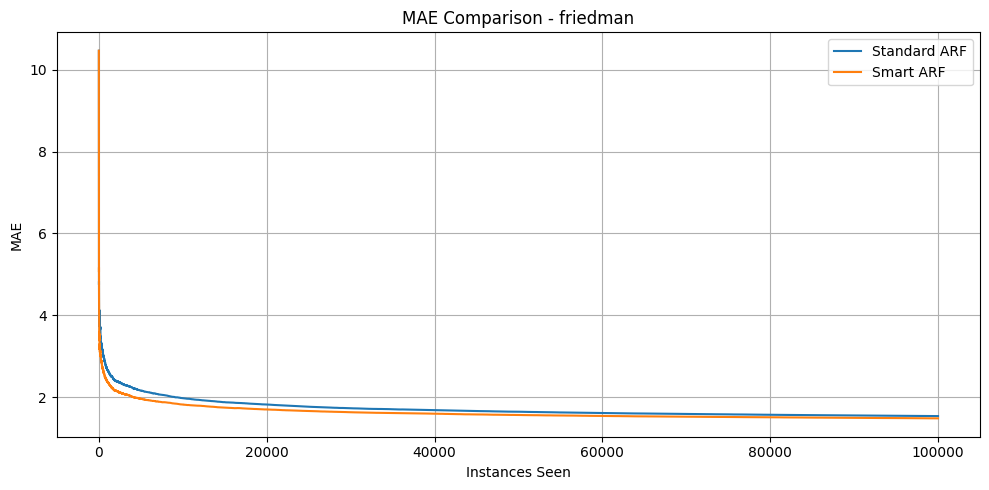

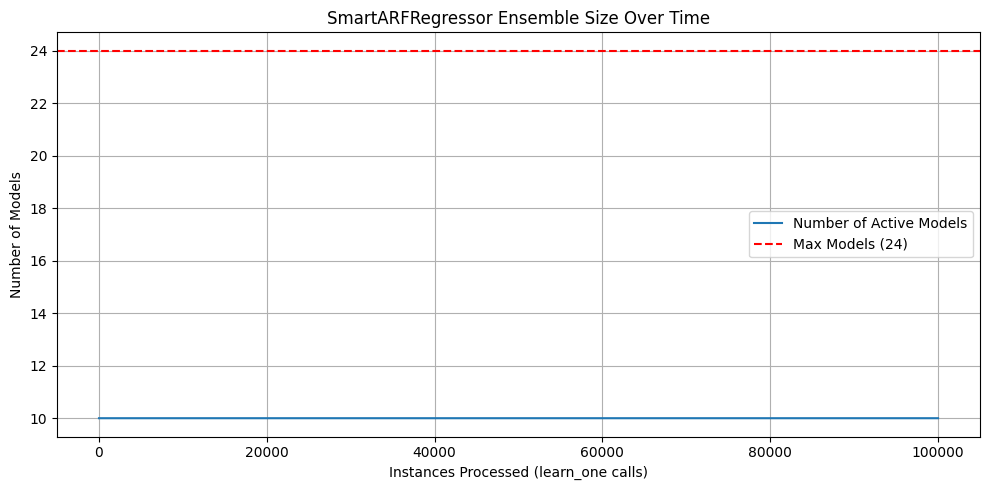

✅ ARFF saved: arff_exports/friedman_smart.arff

📊 [FRIEDMAN_DRIFT]
Standard ARF: MAE=1.5899, R2=0.8239
Smart    ARF: MAE=1.5323, R2=0.8367


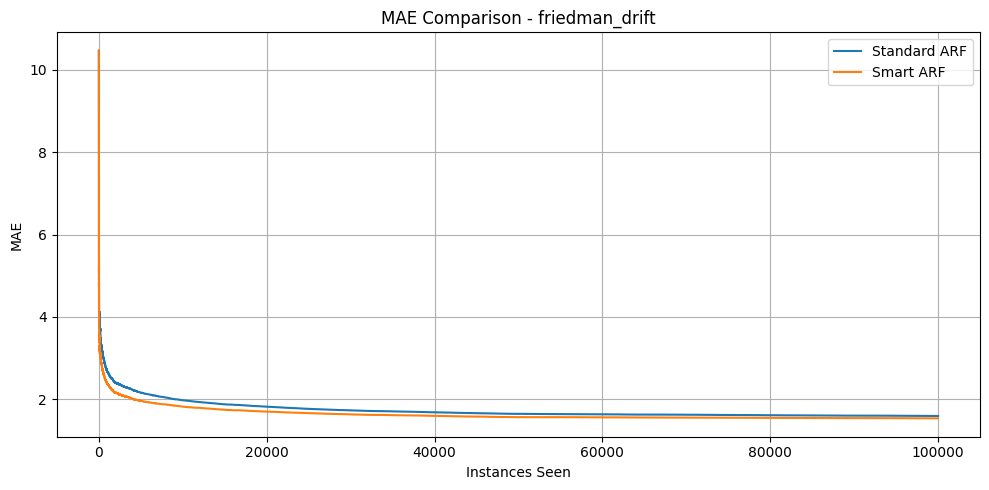

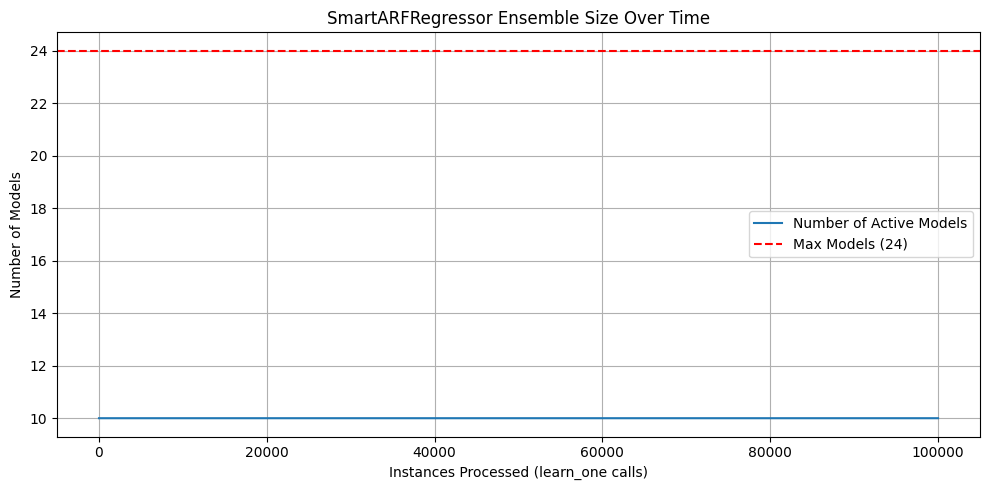

✅ ARFF saved: arff_exports/friedman_drift_smart.arff

📊 [PLANES2D]
Standard ARF: MAE=1.1098, R2=0.8985
Smart    ARF: MAE=0.8658, R2=0.9386


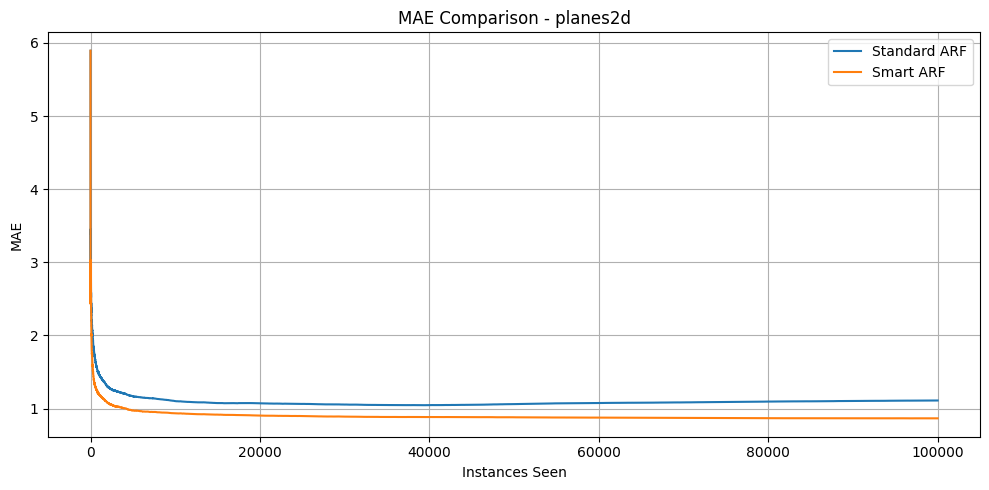

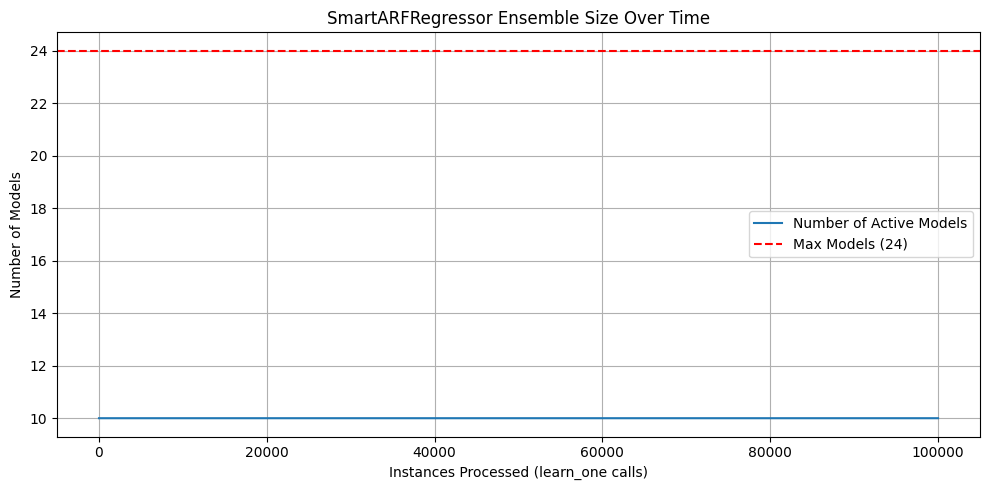

✅ ARFF saved: arff_exports/planes2d_smart.arff

✅ All results saved to regression_results_smart.csv


In [7]:
import os
import csv
from itertools import tee
import matplotlib.pyplot as plt

from river import metrics, preprocessing, forest
from river.drift import ADWIN
from river.datasets import synth

csv_path = "regression_results_smart.csv"
fieldnames = ["dataset", "model", "MAE", "RMSE", "R2", "MAPE"]
if not os.path.exists(csv_path):
    with open(csv_path, mode="w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

# --------------------------
# ARFF Export
# --------------------------
def save_stream_to_arff(stream, relation_name, output_file):
    stream = list(stream)
    if not stream:
        raise ValueError("Stream is empty")

    x_example, _ = stream[0]
    features = list(x_example.keys())
    labels = sorted(set(y for _, y in stream))

    with open(output_file, "w") as f:
        f.write(f"@RELATION {relation_name}\n\n")
        for feat in features:
            f.write(f"@ATTRIBUTE {feat} NUMERIC\n")
        f.write(f"@ATTRIBUTE class {{{', '.join(map(str, labels))}}}\n\n")
        f.write("@DATA\n")
        for x, y in stream:
            row = [str(x[feat]) for feat in features] + [str(y)]
            f.write(",".join(row) + "\n")
    print(f"✅ ARFF saved: {output_file}")

# --------------------------
# Evaluation Function
# --------------------------
def evaluate_smart_vs_standard(name, stream):
    stream_std, stream_smart = tee(stream, 2)

    # --- Models ---
    model_std = (
        preprocessing.StandardScaler() |
        forest.ARFRegressor(
            n_models=25,
            seed=42,
            lambda_value=6,
            grace_period=50,
            leaf_prediction="adaptive"
        )
    )

    model_smart = SmartARFRegressor(
        n_models=10,
        max_models=24,
        grace_period=50,
        lambda_value=6,
        seed=42,
        leaf_prediction="adaptive",
        metric=metrics.MAE(),
        drift_detector=ADWIN(delta=0.001),
        warning_detector=ADWIN(delta=0.01),
        disable_weighted_vote=False,  # Enable smart voting
        monitor_window=200,
        accuracy_drop_threshold=0.6,
        regression_pruning_error_threshold=0.2
    )

    # --- Metrics ---
    std_metrics = {
        "MAE": metrics.MAE(),
        "RMSE": metrics.RMSE(),
        "R2": metrics.R2(),
        "MAPE": metrics.MAPE()
    }
    smart_metrics = {
        "MAE": metrics.MAE(),
        "RMSE": metrics.RMSE(),
        "R2": metrics.R2(),
        "MAPE": metrics.MAPE()
    }

    # --- MAE curves ---
    std_mae, smart_mae = [], []

    for x, y in stream_std:
        y_pred = model_std.predict_one(x)
        if y_pred is not None:
            for m in std_metrics.values():
                m.update(y, y_pred)
        model_std.learn_one(x, y)
        std_mae.append(std_metrics["MAE"].get())

    for x, y in stream_smart:
        y_pred = model_smart.predict_one(x)
        if y_pred is not None:
            for m in smart_metrics.values():
                m.update(y, y_pred)
        model_smart.learn_one(x, y)
        smart_mae.append(smart_metrics["MAE"].get())

    # --- Output to console ---
    print(f"\n📊 [{name.upper()}]")
    print(f"Standard ARF: MAE={std_metrics['MAE'].get():.4f}, R2={std_metrics['R2'].get():.4f}")
    print(f"Smart    ARF: MAE={smart_metrics['MAE'].get():.4f}, R2={smart_metrics['R2'].get():.4f}")

    # --- Save to CSV ---
    with open(csv_path, mode="a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writerow({
            "dataset": name,
            "model": "Standard ARF",
            **{k: f"{m.get():.4f}" for k, m in std_metrics.items()}
        })
        writer.writerow({
            "dataset": name,
            "model": "Smart ARF",
            **{k: f"{m.get():.4f}" for k, m in smart_metrics.items()}
        })

    # --- Plot MAE ---
    plt.figure(figsize=(10, 5))
    plt.plot(std_mae, label="Standard ARF")
    plt.plot(smart_mae, label="Smart ARF")
    plt.title(f"MAE Comparison - {name}")
    plt.xlabel("Instances Seen")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Model Count (Smart only) ---
    if hasattr(model_smart, "model_count_history"):
        model_smart.plot_model_count()

# --------------------------
# Dataset Setup
# --------------------------
regression_datasets = [
    ("friedman", synth.Friedman(seed=1).take(100000)),
    ("friedman_drift", synth.FriedmanDrift(seed=1).take(100000)),
    ("planes2d", synth.Planes2D(seed=1).take(100000))
]

output_dir = "arff_exports"
os.makedirs(output_dir, exist_ok=True)

# --------------------------
# Run Evaluation
# --------------------------
for name, stream in regression_datasets:
    stream_eval, stream_arff = tee(stream, 2)
    evaluate_smart_vs_standard(name, stream_eval)
    save_stream_to_arff(
        stream_arff,
        relation_name=name,
        output_file=os.path.join(output_dir, f"{name}_smart.arff")
    )

print(f"\n✅ All results saved to {csv_path}")
